# Feature Extraction and Classification on Guitarset

## Part 1: Feature Extraction
To classify guitar recordings of 5 different genres

## Initialization

In [52]:
#If not installed, install Essentia. 
# This cell is for running the notebook in Colab
import importlib.util
if importlib.util.find_spec('essentia') is None:
    !pip install essentia

!pip install mirdata
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
# Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np

# Imports to support MIR
import mirdata
import essentia.standard as ess
import pandas as pd


## Data processing

In [54]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Initialize the dataset with a specific local folder on drive and download the relevant elements, then load ids and tracks and visualize one

In [55]:
guitarset = mirdata.initialize("guitarset", data_home="/content/drive/MyDrive/MIR/guitarset")
# guitarset.download(partial_download=['annotations', 'audio_mic']) # partially download data locally 
guitarset.validate

In [56]:
guitarset_ids = guitarset.track_ids  # Load IDs
guitarset_data = guitarset.load_tracks()  # Load data

print('number of elements in the dataset:',len(guitarset_ids))

guitarset_data[guitarset_ids[359]]  # Visualize a single track (the last one)

number of elements in the dataset: 360


Track(
  audio_hex_cln_path="/content/drive/MyDrive/MIR/guitarset/audio_hex-pickup_debleeded/05_SS3-98-C_solo_hex_cln.wav",
  audio_hex_path="/content/drive/MyDrive/MIR/guitarset/audio_hex-pickup_original/05_SS3-98-C_solo_hex.wav",
  audio_mic_path="/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/05_SS3-98-C_solo_mic.wav",
  audio_mix_path="/content/drive/MyDrive/MIR/guitarset/audio_mono-pickup_mix/05_SS3-98-C_solo_mix.wav",
  jams_path="/content/drive/MyDrive/MIR/guitarset/annotation/05_SS3-98-C_solo.jams",
  mode="solo",
  player_id="05",
  style="Singer-Songwriter",
  tempo=98.0,
  track_id="05_SS3-98-C_solo",
  audio_hex: Hexaphonic audio (6-channels) with one channel per string

        Returns,
  audio_hex_cln: Hexaphonic audio (6-channels) with one channel per string
           after bleed removal

        Returns,
  audio_mic: The track's audio

        Returns,
  audio_mix: Mixture audio (mono)

        Returns,
  beats: ,
  inferred_chords: ,
  key_mode: ,
  leadsheet_cho

Determine the number of different styles/genres to be used as classes 

In [57]:
# Get complete list of different genres in the dataset
style_names = []
for i in guitarset_ids:
    style_names.append(guitarset_data[i].style)
style_names = np.unique(style_names)

print(style_names)

['Bossa Nova' 'Funk' 'Jazz' 'Rock' 'Singer-Songwriter']


Create a dictionary with the styles/genres as keys

In [58]:
style_dict = {item: [] for item in style_names}
for i in guitarset_ids:
    style_dict[guitarset_data[i].style].append(guitarset_data[i].audio_mic_path)

style_dict['Rock'] # visualize all the entries in the Rock style

['/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock1-130-A_comp_mic.wav',
 '/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock1-130-A_solo_mic.wav',
 '/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock1-90-C#_comp_mic.wav',
 '/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock1-90-C#_solo_mic.wav',
 '/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock2-142-D_comp_mic.wav',
 '/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock2-142-D_solo_mic.wav',
 '/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock2-85-F_comp_mic.wav',
 '/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock2-85-F_solo_mic.wav',
 '/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock3-117-Bb_comp_mic.wav',
 '/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock3-117-Bb_solo_mic.wav',
 '/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock3-148-C_comp_mic.wav',
 '/content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Rock3-148-C_solo_mi

Plotting one random sample per style

Plot waveforms of random samples of each stroke type...


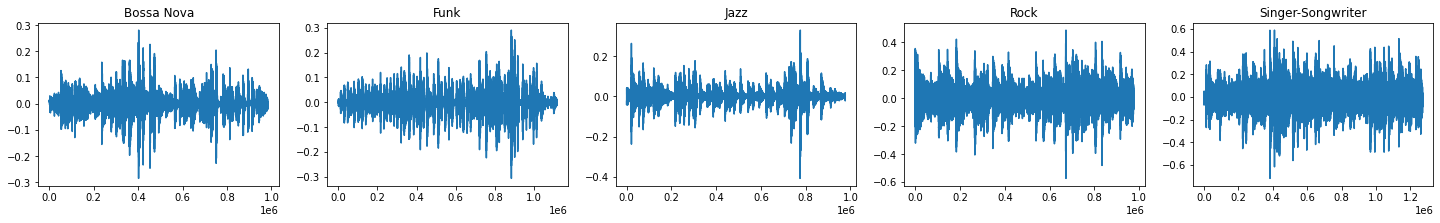

In [59]:
# Raw-data preprocess analysis parameters

_, fs = guitarset_data[guitarset_ids[0]].audio_mic

num_style = len(style_dict.keys())
print("Plot waveforms of random samples of each stroke type...")
plt.figure(1, figsize=(5 * num_style, 3))
file_ind_inlist = 0 # 0: let's take the first file in the list for sample plots
for i, style in enumerate(style_dict.keys()):
    sample_file = style_dict[style][file_ind_inlist]
    x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
    
    plt.subplot(1,num_style,(i+1))
    plt.plot(x)
    plt.title(style)

## Preprocessing of raw data: Segmentation, splitting, alignment,... 

The `split_file()` function is left here only for further testing purposes, but it's not really used since it's not required for this task.

In [67]:
# creating a local sample_data folder with bash
! mkdir /content/drive/MyDrive/MIR/guitarset/sample_data

In [60]:
# Raw-data preprocess analysis parameters
windowSize = 1024
hopSize = 512
NRG_threshold_ratio = 0.00 #threshold expressed as ratio with respect to the maximum value
#Let's put in a container to be able to use as a single argument in function calls
params = {"fs":fs, "windowSize":windowSize, "hopSize":hopSize, "NRG_threshold_ratio": NRG_threshold_ratio}

In [61]:
#Function definition
def split_file(filename, params):
    '''Function to define split boundaries based on a fixed energy threshold
    '''
    x = ess.MonoLoader(filename = filename, sampleRate = fs)()
    NRG = [];
    #Main windowing and feature extraction loop
    for frame in ess.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
        NRG.append(ess.Energy()(frame))
    NRG = np.array(NRG)
    NRG = NRG / np.max(NRG)
    
    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > NRG_threshold_ratio] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (x, NRG, split_decision_func, start_indexes, stop_indexes)

Sample plots for waveform versus energy and splits based on energy threshold


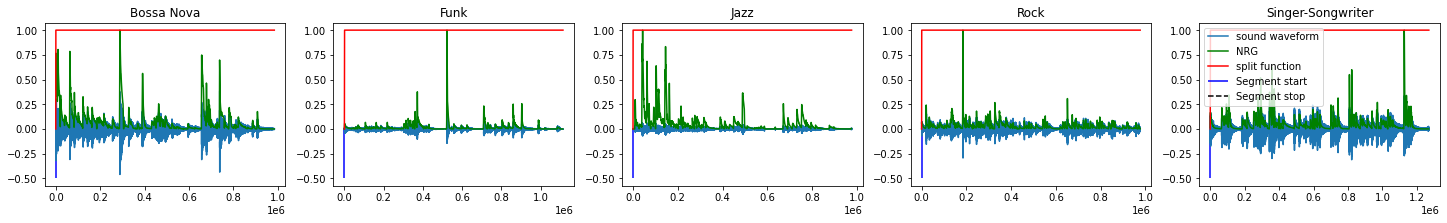

In [62]:
num_style = len(style_names)
print("Sample plots for waveform versus energy and splits based on energy threshold")

file_indexes = [1]
for file_ind_inlist in file_indexes:
    plt.figure(file_ind_inlist, figsize=(5 * num_style, 3))
    for i, style in enumerate(style_dict.keys()):
        sample_file = style_dict[style][file_ind_inlist]
        (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
        #Plotting functions for checking the split decisions
        plt.subplot(1,num_style,(i+1))
        plt.title(style)
        plt.plot(x, label = 'sound waveform')
        plt.plot(np.arange(NRG.size) * hopSize, NRG, 'g', label = 'NRG')
        plt.plot(np.arange(split_decision_func.size) * hopSize, split_decision_func,'r', label = 'split function')
        plt.vlines(start_indexes, ymin = -0.5, ymax = 0, colors='b', linestyles='solid', label='Segment start')
        plt.vlines(stop_indexes, ymin = -0.5, ymax = 0, colors='k', linestyles='dashed', label='Segment stop')

plt.legend(loc="best");


Splitting file is not necessary for this task

In [ ]:
# main_data_dir = 'sample_data'
# if not os.path.exists(main_data_dir): #creating the directory
#     os.mkdir(main_data_dir)
# segments_dir = os.path.join(main_data_dir,'segments')
# if not os.path.exists(segments_dir): #creating the directory
#     os.mkdir(segments_dir)

# segment_files = []
# for style, files in style_dict.items():
#     for sample_file in files:
#         #Get file id
#         stroke_id =  sample_file.split('__')[-1].split('.')[0]
#         x = ess.MonoLoader(filename = sample_file, sampleRate = fs)()
#         (x, NRG, split_decision_func, start_indexes, stop_indexes) = split_file(sample_file, params)
#         #Croping segments
#         for start, stop in zip(start_indexes, stop_indexes):
#             x_seg = x[start: stop]
#             #Final check for amplitude (to avoid silent segments selection due to noise in split function)
#             if(np.max(np.abs(x_seg)) > 0.05):
#                 #Amplitude normalisation
#                 x_seg = x_seg / np.max(np.abs(x_seg))
#                 filename = os.path.join(segments_dir, stroke_id + '.wav')
#                 ess.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
#                 segment_files.append(filename)

# print(len(segment_files),'segment files created')

In [70]:
#If required, you can use this cell to delete all files in a given folder

def delete_files_in_dir(dir_name):
    '''Deleting all files in a directory
    '''
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

# delete_files_in_dir('/content/sample_data')

## Feature extraction 

Compute a list of common low-level features for each of the files and form a data frame including features and categories. Using the [MusicExtractor function of Essentia](https://essentia.upf.edu/documentation/reference/std_MusicExtractor.html) that would compute a large number of features commonly used in MIR literature. 

In [63]:
# Print descriptors to be considered
features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                      lowlevelFrameSize = 2048,
                                                      lowlevelHopSize = 1024,
                                                      lowlevelStats = ['mean', 'stdev'])(guitarset_data["03_Rock2-142-D_comp"].audio_mic_path)

scalar_lowlevel_descriptors = [descriptor for descriptor in features.descriptorNames() if 'lowlevel' in descriptor and isinstance(features[descriptor], float)]
print("Subset of features to be considered:\n",scalar_lowlevel_descriptors)

Subset of features to be considered:
 ['lowlevel.average_loudness', 'lowlevel.barkbands_crest.mean', 'lowlevel.barkbands_crest.stdev', 'lowlevel.barkbands_flatness_db.mean', 'lowlevel.barkbands_flatness_db.stdev', 'lowlevel.barkbands_kurtosis.mean', 'lowlevel.barkbands_kurtosis.stdev', 'lowlevel.barkbands_skewness.mean', 'lowlevel.barkbands_skewness.stdev', 'lowlevel.barkbands_spread.mean', 'lowlevel.barkbands_spread.stdev', 'lowlevel.dissonance.mean', 'lowlevel.dissonance.stdev', 'lowlevel.dynamic_complexity', 'lowlevel.erbbands_crest.mean', 'lowlevel.erbbands_crest.stdev', 'lowlevel.erbbands_flatness_db.mean', 'lowlevel.erbbands_flatness_db.stdev', 'lowlevel.erbbands_kurtosis.mean', 'lowlevel.erbbands_kurtosis.stdev', 'lowlevel.erbbands_skewness.mean', 'lowlevel.erbbands_skewness.stdev', 'lowlevel.erbbands_spread.mean', 'lowlevel.erbbands_spread.stdev', 'lowlevel.hfc.mean', 'lowlevel.hfc.stdev', 'lowlevel.loudness_ebu128.integrated', 'lowlevel.loudness_ebu128.loudness_range', 'lowlev

Running Essentia MusicExtractor for all files, keeping a subset of features, writing to an output file: data.csv.

**The use of 'style' has been replaced by 'genre' to avoid confusion later in the classification**

In [71]:
import csv

# Extracting features and writing in data.csv file in the segments folder
#  each line in the data.csv file represents a sample with features and the class information as the last element

data_file = '/content/drive/MyDrive/MIR/guitarset/sample_data/data.csv'
file_count = 0
with open(data_file, 'w') as writer:
    #adding column names as the first line in csv
    line2write = ','.join(scalar_lowlevel_descriptors + ['genre']).replace('lowlevel.','') + '\n'
    writer.write(line2write)
    for style, files in style_dict.items():
        for sample_file in files:
          file_count +=1
          if file_count % 20 == 0: #print name of a file every 20 files
              print(file_count, "files processed, current file: ", sample_file)

          #Compute and write features for file
          features, features_frames = ess.MusicExtractor(lowlevelSilentFrames='drop',
                                                        lowlevelFrameSize = 2048,
                                                        lowlevelHopSize = 1024,
                                                        lowlevelStats = ['mean', 'stdev'])(sample_file)
          selected_features = [features[descriptor] for descriptor in scalar_lowlevel_descriptors]
          label = sample_file.split('/')[-1].split('.')[0].split('-')[0].split('_')[-1]
          unified_label = label[:-1]
          line2write = str(selected_features)[1:-1] + ',' + unified_label + '\n'
          writer.write(line2write)
print("A total of ", file_count, "files processed")

20 files processed, current file:  /content/drive/MyDrive/MIR/guitarset/audio_mono-mic/01_BN2-166-Ab_solo_mic.wav
40 files processed, current file:  /content/drive/MyDrive/MIR/guitarset/audio_mono-mic/03_BN1-147-Gb_solo_mic.wav
60 files processed, current file:  /content/drive/MyDrive/MIR/guitarset/audio_mono-mic/04_BN3-154-E_solo_mic.wav
80 files processed, current file:  /content/drive/MyDrive/MIR/guitarset/audio_mono-mic/00_Funk2-119-G_solo_mic.wav
100 files processed, current file:  /content/drive/MyDrive/MIR/guitarset/audio_mono-mic/02_Funk1-97-C_solo_mic.wav
120 files processed, current file:  /content/drive/MyDrive/MIR/guitarset/audio_mono-mic/03_Funk3-98-A_solo_mic.wav
140 files processed, current file:  /content/drive/MyDrive/MIR/guitarset/audio_mono-mic/05_Funk2-119-G_solo_mic.wav
160 files processed, current file:  /content/drive/MyDrive/MIR/guitarset/audio_mono-mic/01_Jazz1-200-B_solo_mic.wav
180 files processed, current file:  /content/drive/MyDrive/MIR/guitarset/audio_mon

In [72]:
#Read data with pandas module
data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,...,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,genre
0,0.678595,17.053658,5.359172,0.323045,0.095043,44.568661,109.956329,2.969123,3.602786,4.651040,...,354.715088,3.788053,1.843491,2912615.25,1574234.125,0.773643,0.731553,0.017444,0.012978,BN
1,0.498945,15.277541,5.771532,0.255574,0.087297,11.360999,19.550810,2.116331,1.717938,9.209044,...,599.172485,3.197023,1.859064,2894353.25,1406329.375,0.958381,1.027366,0.031643,0.022105,BN
2,0.958746,13.777791,4.144764,0.280946,0.093710,29.206335,86.143341,2.965204,2.741709,5.926824,...,378.314056,3.303911,1.900117,3341306.25,1554873.125,0.635393,0.641100,0.019124,0.014579,BN
3,0.908284,14.065392,3.930786,0.261140,0.074184,10.322021,15.642951,2.402953,1.101622,7.842619,...,408.312958,3.308775,1.574728,2523977.25,1350682.125,0.797930,0.542715,0.020422,0.009778,BN
4,0.689578,15.046312,5.136526,0.257579,0.086898,42.263268,150.816269,3.522104,3.901124,7.926633,...,649.332947,2.534678,1.302398,3900088.75,1733229.250,0.704390,0.891672,0.024933,0.018857,BN


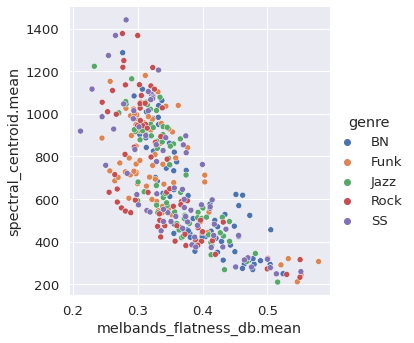

In [143]:
# Take two random features and plot the sample points
import seaborn as sns
sns.relplot(x = "melbands_flatness_db.mean", y = "spectral_centroid.mean", hue = "genre", data = data);

### Preprocessing of the features


In [76]:
data_modif = data.copy()

#Let's use sklearn's preprocessing tools for applying normalisation to features
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data_modif.iloc[:,:84] = min_max_scaler.fit_transform(data.iloc[:,:84].values)

In [77]:
# Checking if our data is balanced (if not, we should balance it to prevent our model to be baised)
data_modif.genre.value_counts()

BN      72
Funk    72
Jazz    72
Rock    72
SS      72
Name: genre, dtype: int64

## Supervised learning approach (Support Vector Machines)

In [78]:
# Input values put in a matrix, there are 84 features
X = data_modif.iloc[:,:84].values 
# Creating output values
data_modif.genre = pd.Categorical(data_modif.genre)  # convert to categorical data
y = np.array(data_modif.genre.cat.codes)  # create label encoded outputs
# Print the first sample
print("Features of the first sample: ", X[0])
print("Class of the first sample: ", y[0])

Features of the first sample:  [0.69183178 0.64224512 0.64433714 0.58412362 0.43103048 0.20001124
 0.15140456 0.30579204 0.32247982 0.19163271 0.37308766 0.55433906
 0.41004973 0.17391654 0.74677349 0.65972939 0.5479318  0.48319052
 0.71745543 0.57491047 0.82094836 0.81446883 0.34824812 0.57653903
 0.11431476 0.04396984 0.46411878 0.42112137 0.47471967 0.15588942
 0.4681786  0.25458868 0.63309727 0.56216279 0.56925499 0.44682931
 0.16259601 0.01729041 0.42854391 0.16429035 0.13356592 0.24898635
 0.45050731 0.53862863 0.91922105 0.28591214 0.71024618 0.55518977
 0.36734693 0.87910579 0.16708064 0.28302283 0.16021525 0.27492028
 0.67416467 0.33166452 0.30956003 0.30956364 0.06157792 0.03450062
 0.12518326 0.21721485 0.03945818 0.03766526 0.50525406 0.36876595
 0.31060058 0.55965862 0.37941953 0.39383434 0.17736651 0.14475831
 0.44429368 0.44528392 0.09677461 0.1856304  0.30243285 0.28025121
 0.48542716 0.40402325 0.29671721 0.19747036 0.17516902 0.23635494]
Class of the first sample:  0


In [79]:
# Let's split data into test and train sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Check sizes of input and output vectors
print("Size of train features matrix: ",X_train.shape, ", Size of train output vector: ",y_train.shape)
print("Size of test features matrix: ",X_test.shape, ", Size of test output vector: ",y_test.shape)

Size of train features matrix:  (241, 84) , Size of train output vector:  (241,)
Size of test features matrix:  (119, 84) , Size of test output vector:  (119,)


In [80]:
# Define and train the model

from sklearn import svm
clf = svm.SVC(gamma = 1 / (X_train.shape[-1] * X_train.var()))

# Fit model with training data
clf.fit(X_train, y_train)

# Predict classes of test samples
y_pred = clf.predict(X_test)

In [81]:
# Test the model
# Let's check for each sample in the test set if prediction matches the true class information
y_test == y_pred

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
        True, False,  True,  True, False,  True, False,  True, False,
       False,  True, False, False, False, False, False,  True, False,
        True, False,  True,  True,  True, False, False, False, False,
        True, False, False, False,  True,  True,  True, False, False,
       False, False, False,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False,  True, False, False,  True, False,
        True, False,  True, False,  True, False, False, False,  True,
        True, False, False,  True,  True, False,  True, False,  True,
       False,  True, False, False, False, False, False, False,  True,
       False,  True])

In [82]:
# Data is balanced, so you can use accuracy as a measure:
print("accuracy: ", np.sum(y_test == y_pred)/len(y_test))

accuracy:  0.453781512605042


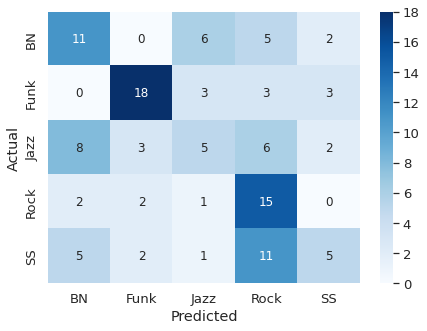

In [83]:
# Print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

classes = np.unique(data_modif.genre)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred), columns = classes, index = classes)
conf_mat.index.name = 'Actual'
conf_mat.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale = 1.2)
sns.heatmap(conf_mat, cmap = "Blues", annot_kws = {"size": 12}, annot = True);

## Supervised learning approach (Neural Network)

In [84]:
from sklearn.preprocessing import StandardScaler

# Let's start by splitting our data 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1)

# ..and apply normalisation
scaler = StandardScaler().fit(X_train_val)
norm_x_train_val = scaler.transform(X_train_val)
norm_x_test = scaler.transform(X_test)

In [85]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train_val_onehot = onehot_encoder.fit_transform(y_train_val.reshape(len(y_train_val), 1))
y_test_onehot = onehot_encoder.fit_transform(y_test.reshape(len(y_test), 1))
print("One-hot encoded y_train_val shape = ", y_train_val_onehot.shape)
print("One-hot encoded y_test shape = ", y_test_onehot.shape)

One-hot encoded y_train_val shape =  (288, 5)
One-hot encoded y_test shape =  (72, 5)


In [86]:
from keras.models import Sequential
from keras import layers

def compose_model(num_features):
    
    model = Sequential()

    # Input layer 
    model.add(layers.BatchNormalization(name='InputLayer', input_shape=(num_features,)))
    
    # 1. hidden layer
    model.add(layers.Dense(name='HiddenLayer_1', units = 40))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('tanh'))
    model.add(layers.Dropout(0.3))

    # 2. hidden layer
    model.add(layers.Dense(name='HiddenLayer_2', units = 20))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    model.add(layers.Dense(name='Output_layer', units = 5))
    model.add(layers.Activation('sigmoid'))
    
    return model

model = compose_model(X_train_val.shape[1])

In [87]:
model.summary()  # Plot summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (BatchNormalizat  (None, 84)               336       
 ion)                                                            
                                                                 
 HiddenLayer_1 (Dense)       (None, 40)                3400      
                                                                 
 batch_normalization (BatchN  (None, 40)               160       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40)                0         
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 HiddenLayer_2 (Dense)       (None, 20)                8

In [88]:
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
summary = model.fit(X_train_val, y_train_val_onehot, batch_size = 50, epochs = 250, validation_split=0.2, verbose=0)

In [89]:
score = model.evaluate(X_test, y_test_onehot, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4563722610473633
Test accuracy: 0.4166666567325592


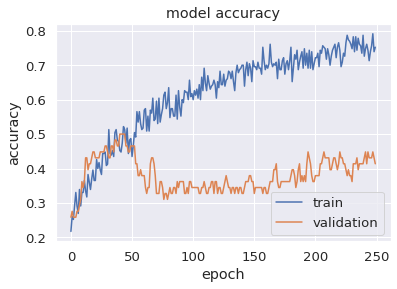

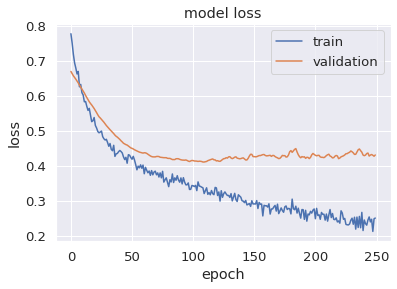

In [90]:
# summarize history for accuracy
plt.plot(summary.history['accuracy'])
plt.plot(summary.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(summary.history['loss'])
plt.plot(summary.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Part 2: Sound classification

In [91]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=f14e84e3aa48aab4f41ffb4b4394535d91341509acc71c9ea6907e4328e9da2c
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=5ec4b6d858a55d690c74530df19edb787ea5a20099b9cad225bd94965edec81f
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [92]:
# We'll need numpy and pandas for basic data wrangling
import numpy as np
import pandas as pd

# We'll need matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# We'll use some preprocessing from scikit-learn:
#  Standard scaling (z-scoring) and label encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Our classifier will be 1-nearest-neighbor after learning the distance metric
from sklearn.neighbors import KNeighborsClassifier

# Pipelines make it a little easier to manage sequences of models,
# eg scaler -> metric learner -> 1nn
from sklearn.pipeline import make_pipeline

# We'll use some standard machinery for reporting accuracy of our models
from sklearn.metrics import classification_report,  plot_confusion_matrix

from sklearn.model_selection import train_test_split

RNG_STATE = 0

from google.colab import files

# Train test splitting using sklearn
X_train, X_test, y_train_text, y_test_text = train_test_split(data[data.columns[:-1]],data[data.columns[-1]], test_size=0.2, random_state=RNG_STATE)

In [93]:
# We'll need to use a label encoder to encode our instrument
# names as numeric identifiers (0, 1, 2, ..., 9)
encoder = LabelEncoder()

# "Fit" on the training labels; this is really just specifying our vocabulary
# transform maps the encoding over the list of strings to give our encoded label array
y_train = encoder.fit_transform(y_train_text)

# Since the encoder is already fit, we can now transform our test set labels as well
y_test = encoder.transform(y_test_text)

              precision    recall  f1-score   support

          BN       0.47      0.53      0.50        17
        Funk       0.62      0.76      0.68        17
        Jazz       0.50      0.23      0.32        13
        Rock       0.50      0.35      0.41        17
          SS       0.21      0.38      0.27         8

    accuracy                           0.47        72
   macro avg       0.46      0.45      0.44        72
weighted avg       0.49      0.47      0.46        72



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


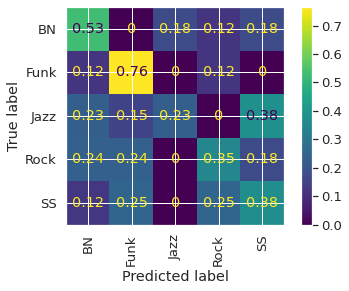

In [94]:
# Our classifier is a "pipeline": scaling followed by KNN
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

# Fit all stages of the pipeline to our training data
clf.fit(X_train, y=y_train)

# How well does our 1-Nearest neighbor model work?
y_pred = clf.predict(X_test)

# Compare our predictions to the true labels in y_test
report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

# Finally, plot a confusion matrix showing how mistakes are distributed
plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

## Feature visualization

In [95]:
### How to visualize features using metric learning https://github.com/bmcfee/ismir2020-metric-learning
# scikit-learn provides Linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Finally, umap will let us map high-dimensional data down to 2-d for plotting
import umap

We visualize the data by applying a transformation using UMAP from a high dimensional space to a low dimensional space. Similarly to the PCA reduction, the output axes do not hold any specific meaning.

In [96]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll apply all but the last stage (KNN classifier) of our pipeline to the data.
# In this case, we just have one previous stage, which does feature normalization.
# This will change in subsequent examples.

X_train_transformed = clf[:-1].transform(X_train)
X_test_transformed = clf[:-1].transform(X_test)

# Fit on the transformed data, and then transform the test data
embed = reducer.fit_transform(X_train_transformed)
embed_test = reducer.transform(X_test_transformed)

In the plot the different classes are plotted with different colors, while the train and test datasets are denoted by x or circles.
If the test and training data of the same color appear near each other in the visualization, then nearest neighbor classification should work well.

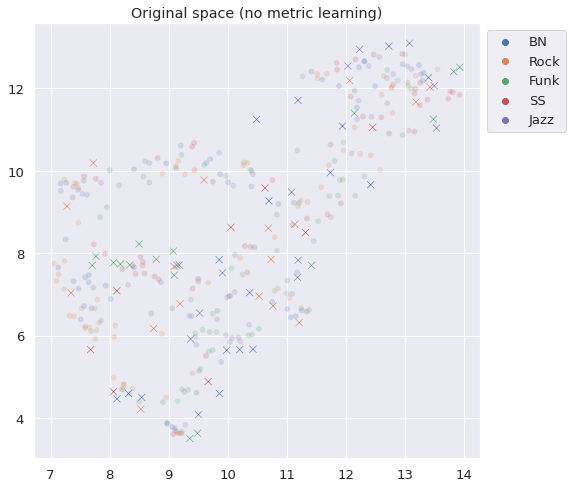

In [97]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Original space (no metric learning)');

## Linear projection of features

We use Linear Discriminant Analysis to better separate the classes by learning a 5-dimensional projection of the features. 

[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing lineardiscriminantanalysis, total=   0.0s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
              precision    recall  f1-score   support

          BN       0.64      0.53      0.58        17
        Funk       0.79      0.88      0.83        17
        Jazz       0.38      0.38      0.38        13
        Rock       0.50      0.47      0.48        17
          SS       0.20      0.25      0.22         8

    accuracy                           0.54        72
   macro avg       0.50      0.50      0.50        72
weighted avg       0.55      0.54      0.54        72



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


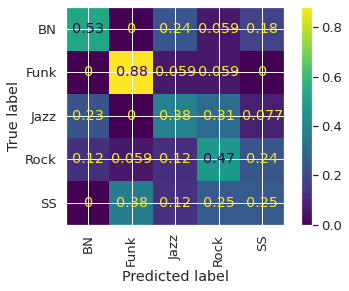

In [98]:
clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(), KNeighborsClassifier(n_neighbors=1), verbose=True)
clf.fit(X_train, y=y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

Let's visualize the results: 

In [99]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll fit the umap embedding on the data after applying our learned transformation
embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

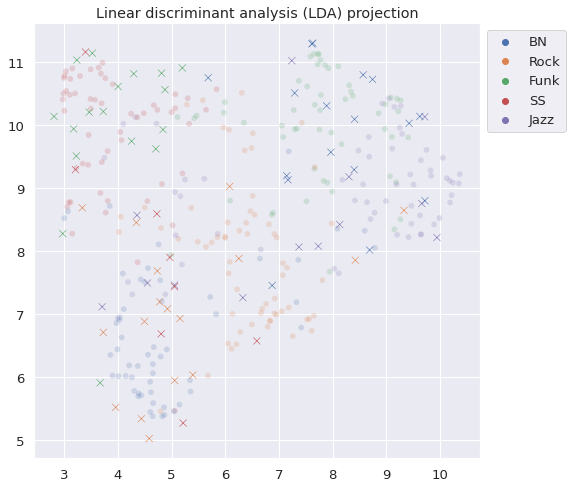

In [100]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Linear discriminant analysis (LDA) projection');

The projection learned by LDA tells us the weight assigned to each of the training features. 

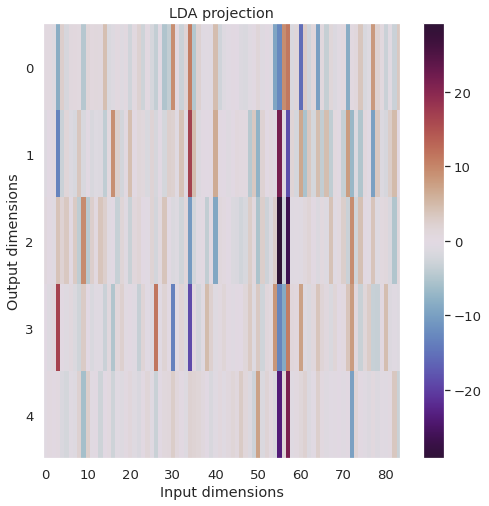

In [101]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[1][1]
weights = model.coef_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax)
ax.grid(False)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='LDA projection');

Which features are given more importance?

Select and print the single most important feature:

In [127]:
highest_weight = np.max(weights)
for i in range(len(weights)):
  if (weights[i] == highest_weight).any():
    print(data.columns[:-1][i])

barkbands_crest.stdev


Select and print the 5 most important features:

In [137]:
sorted_indices = np.argsort(-np.array(weights))

for i in range(len(sorted_indices)):
  print(data.columns[:-1][i])

average_loudness
barkbands_crest.mean
barkbands_crest.stdev
barkbands_flatness_db.mean
barkbands_flatness_db.stdev
